In [37]:
import os
import pickle
import torch
import numpy as np
import scipy.sparse as sp
import dgl

from utils import select_source, compute_rank_error, compute_hit_ratio

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 訓練推薦系統

In [38]:
SEED = 42
EPOCHS = 100
TEST_RATIO = 0.3  # ratio for splitting the test set
DEVICE = "cpu"

In [39]:
with open(os.path.join("facebook", "combined-adj-sparsefeat.pkl"), "rb") as f:
    friendship_matrix, feature_matrix = pickle.load(f, encoding='latin1')

print(f"Friendship matrix shape : {friendship_matrix.shape}")
print(f"Feature matrix shape    : {feature_matrix.shape}")

src, dst = np.nonzero(friendship_matrix)
g = dgl.graph((src, dst))
g.ndata['feat'] = torch.tensor(feature_matrix.todense(), dtype=torch.float32)
g

Friendship matrix shape : (4039, 4039)
Feature matrix shape    : (4039, 1283)


Graph(num_nodes=4039, num_edges=176468,
      ndata_schemes={'feat': Scheme(shape=(1283,), dtype=torch.float32)}
      edata_schemes={})

In [40]:
def split_dataset(g):

    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    np.random.seed( SEED )
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set

    # get positive edges for test and train
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    # split the negative edges for training and testing
    np.random.seed( SEED )
    neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    # construct positive and negative graphs for training and testing
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

    # training graph
    train_g = dgl.remove_edges(g, eids[:test_size])
    train_g = dgl.add_self_loop(train_g)

    return {
        "train_pos_g": train_pos_g,
        "train_neg_g": train_neg_g,
        "test_pos_g":  test_pos_g,
        "test_neg_g":  test_neg_g,
        "train_g":     train_g
    }

In [41]:
from model import Pipeline

pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
#pipeline = Pipeline("SAGE", 16, feature_matrix.shape[1])
ds = split_dataset(g)
train_losses = pipeline.train(ds)

100%|██████████| 100/100 [00:02<00:00, 48.77it/s]


AUC: 0.968110


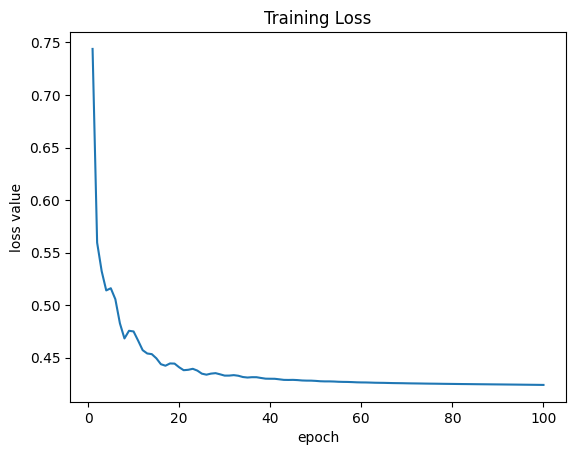

In [42]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.plot(range(1, EPOCHS+1), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

In [43]:
recommend_list = pipeline.recommend(g, 0)
print(recommend_list[:10])

[(3632, 7.010799884796143), (3089, 4.877986907958984), (3682, 4.2327880859375), (3675, 3.922748327255249), (3634, 3.6718087196350098), (3650, 3.6258347034454346), (3666, 3.5791165828704834), (3673, 3.453758716583252), (3646, 3.2339255809783936), (3656, 3.2099552154541016)]


### 方法二

In [44]:
MAX_CHANGES = 20
NUM_PAIRS = 30

RESTART_RATIO = 0.1
EPSILON = 1e-5
WALK_GRAPH = "weighted"

取樣一些成對的驗證資料

In [45]:
import random

pairs = []
start = 50
end = 100

random.seed(SEED)
targets = random.sample(range(0, friendship_matrix.shape[0]-1), NUM_PAIRS)

for tgt in targets:
    recommend_list = pipeline.recommend(g, tgt)
    src = select_source(recommend_list, start, end)
    pairs.append((src, tgt))

pairs[:5]

[(2312, 2619), (465, 456), (30, 102), (2830, 3037), (1587, 1126)]

In [46]:
def random_walk_with_restart(graph, start_point, restart_ratio, max_iter=100, tol=1e-6, device=torch.device("cpu")):
    # graph is already torch tensor
    init_vector = torch.zeros((graph.shape[0], 1), device=device)
    init_vector[start_point, 0] = 1
    p = init_vector.clone()
    
    for _ in range(max_iter):
        prev_p = p.clone()
        p = (1 - restart_ratio) * torch.mm(graph, p) + restart_ratio * init_vector
        if torch.norm(p - prev_p, p=1).item() < tol:
            break
    return p

def construct_normalized_graph(friends, features, epsilon=1e-4, walk_graph="weighted", device=torch.device("cpu")):
    if walk_graph == "adj":
        # normalize friends
        friends += epsilon * torch.eye(friends.shape[0], device=device)
        normalized_friends = friends / friends.sum(dim=1, keepdim=True)

    elif walk_graph == "weighted":
        # Compute feature inner product matrix
        feature_inner_product = torch.mm(features, features.t())
        
        # Replace the original adjacency matrix values with feature inner product values
        neighbors = (friends == 1)
        friends = friends.clone()  # Make a copy to avoid modifying the original tensor
        friends[neighbors] = feature_inner_product[neighbors]
        
        # Normalize the friends matrix
        friends += epsilon * torch.eye(friends.shape[0], device=device)
        normalized_friends = friends / friends.sum(dim=1, keepdim=True)

    else:
        raise ValueError("Error in reading parameter walk graph!!")

    return normalized_friends


def method_2(g, pair):
    user_id, tgt = pair
    g_copy = dgl.remove_self_loop(g.clone())
    device = torch.device(DEVICE)
    
    # get friends and feature metrix
    friends = g_copy.adj().to_dense()
    features = g_copy.ndata['feat'].to(device)
    # turn to float
    friends = friends.type(torch.FloatTensor).to(device)

    normalized_friends = construct_normalized_graph(friends, features, EPSILON, WALK_GRAPH, device)
    proximity = random_walk_with_restart(normalized_friends, tgt, RESTART_RATIO, device=device)

    proximity = proximity.reshape(-1).detach().cpu().numpy()

    top_friends = np.flip(np.argsort(proximity))[1:MAX_CHANGES+1]

    friends = friends.detach().cpu().numpy()
    features = features.detach().cpu().numpy()
    friends[top_friends, user_id] = 1
    friends[user_id, top_friends] = 1

    src, dst = np.nonzero(friends)
    g_change = dgl.graph((src, dst))
    g_change.ndata['feat'] = torch.tensor(features, dtype=torch.float32)

    return g_change

In [47]:
from tqdm.auto import tqdm

origin_ranks, new_ranks = [], []

for pair in tqdm(pairs):
    g_change = method_2(g, pair)

    origin_rank = pipeline.predict_rank(g, pair[0], pair[1])

    ds = split_dataset(g_change)
    new_pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
    train_losses = new_pipeline.train(ds)

    #new_rank = pipeline.predict_rank(g_change, pair[0], pair[1])
    new_rank = new_pipeline.predict_rank(g_change, pair[0], pair[1])

    origin_ranks.append(origin_rank)
    new_ranks.append(new_rank)

print( compute_rank_error(origin_ranks, new_ranks) )    

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]



AUC: 0.962531


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



AUC: 0.968090


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]



AUC: 0.959870


100%|██████████| 100/100 [00:27<00:00,  3.63it/s]



AUC: 0.968363


100%|██████████| 100/100 [00:30<00:00,  3.25it/s]



AUC: 0.966643


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]



AUC: 0.967366


100%|██████████| 100/100 [00:02<00:00, 43.75it/s]



AUC: 0.964220


100%|██████████| 100/100 [00:10<00:00,  9.65it/s]



AUC: 0.966652


100%|██████████| 100/100 [00:01<00:00, 54.13it/s]



AUC: 0.963970


100%|██████████| 100/100 [00:24<00:00,  4.11it/s]



AUC: 0.966998


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]



AUC: 0.965279


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]



AUC: 0.968008


100%|██████████| 100/100 [00:01<00:00, 54.34it/s]



AUC: 0.967271


100%|██████████| 100/100 [00:02<00:00, 48.10it/s]



AUC: 0.966164


100%|██████████| 100/100 [00:02<00:00, 38.00it/s]



AUC: 0.966755


100%|██████████| 100/100 [00:02<00:00, 46.51it/s]



AUC: 0.966084


100%|██████████| 100/100 [00:02<00:00, 41.72it/s]



AUC: 0.955989


100%|██████████| 100/100 [00:02<00:00, 44.89it/s]



AUC: 0.967255


100%|██████████| 100/100 [00:02<00:00, 46.95it/s]



AUC: 0.967833


100%|██████████| 100/100 [00:02<00:00, 49.89it/s]



AUC: 0.960247


100%|██████████| 100/100 [00:02<00:00, 45.40it/s]



AUC: 0.964634


100%|██████████| 100/100 [00:01<00:00, 54.95it/s]



AUC: 0.958244


100%|██████████| 100/100 [00:01<00:00, 54.39it/s]



AUC: 0.967482


100%|██████████| 100/100 [00:01<00:00, 52.19it/s]



AUC: 0.967018


100%|██████████| 100/100 [00:01<00:00, 51.47it/s]



AUC: 0.966110


100%|██████████| 100/100 [00:02<00:00, 46.28it/s]



AUC: 0.948547


100%|██████████| 100/100 [00:01<00:00, 57.99it/s]



AUC: 0.966309


100%|██████████| 100/100 [00:01<00:00, 57.42it/s]



AUC: 0.963369


100%|██████████| 100/100 [00:01<00:00, 57.80it/s]



AUC: 0.967905


100%|██████████| 100/100 [00:01<00:00, 56.92it/s]



AUC: 0.966272


100%|██████████| 100/100 [00:01<00:00, 55.95it/s]



AUC: 0.967371


100%|██████████| 100/100 [00:01<00:00, 57.90it/s]



AUC: 0.964556


100%|██████████| 100/100 [00:01<00:00, 55.21it/s]



AUC: 0.920429


100%|██████████| 100/100 [00:13<00:00,  7.31it/s]



AUC: 0.963559


100%|██████████| 100/100 [00:10<00:00,  9.14it/s]



AUC: 0.959313


100%|██████████| 100/100 [00:01<00:00, 59.56it/s]



AUC: 0.966477


100%|██████████| 100/100 [00:01<00:00, 60.83it/s]



AUC: 0.967891


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]



AUC: 0.966728


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]



AUC: 0.962221


100%|██████████| 100/100 [00:07<00:00, 13.27it/s]



AUC: 0.953388


100%|██████████| 40/40 [09:36<00:00, 14.40s/it]

{'average': 7.631578947368421, 'max': 23, 'min': 0}


In [48]:
print(origin_ranks)
print(new_ranks)

[60, 94, 77, 71, 67, 59, 63, 98, 71, 56, 55, 74, 56, 72, 72, 88, 66, 52, 96, 79, 84, 57, 74, 55, 85, 68, 90, 89, 73, 86, 62, 95, 54, 52, 92, 64, 99, 68, 55, 64]
[58, 115, 90, 68, 49, 57, 61, 91, 48, 58, 70, 81, 56, 74, 75, 89, 61, 53, 79, 119, 108, 59, 88, 43, 167, 74, 91, 95, 73, 85, 73, 95, 61, 52, 82, 48, 110, 53, 340, 52]
